In [1]:
Sys.setlocale("LC_ALL", "es_ES.UTF-8") # principalmente para mostrar tildes en las gráficas

library(MASS)
library(ISLR)
library(dplyr)
library(glmnet)
library(caret)
library(ggplot2)

set.seed(2015)

[1] "es_ES.UTF-8/es_ES.UTF-8/es_ES.UTF-8/C/es_ES.UTF-8/C"


Adjuntando el paquete: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Cargando paquete requerido: Matrix

Loaded glmnet 4.1-8

Cargando paquete requerido: ggplot2

Cargando paquete requerido: lattice



## b) Entrenamiento de modelos

In [70]:
data("Boston")
boston_clean <- na.omit(Boston) %>% select(lstat, rm, age, crim, tax, medv)
head(boston_clean)

train <- boston_clean[1:450,]
test <- boston_clean[(450 + 1):nrow(boston_clean), ]

,lstat,rm,age,crim,tax,medv
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4.98,6.575,65.2,0.00632,296,24.0
2,9.14,6.421,78.9,0.02731,242,21.6
3,4.03,7.185,61.1,0.02729,242,34.7
4,2.94,6.998,45.8,0.03237,222,33.4
5,5.33,7.147,54.2,0.06905,222,36.2
6,5.21,6.430,58.7,0.02985,222,28.7


El modelo de regresión lineal toma la forma 
\begin{equation}
Y = \beta_0 + \sum_{j = 1}^p \beta_j X_j + \epsilon
\end{equation}

Estimamos los coeficientes $\beta$ minimizando el RSS
\begin{equation}
\sum_{i = 1}^n \left(y_i - \beta_0 - \sum_{j = 1}^p \beta_j x_{ij}\right)^2
\end{equation}

In [71]:
set.seed(2025)
# REGRESION MULTILINEAL

multi_model <- lm(medv ~ ., data = train)
confint(multi_model, level = 0.95) # intervalos de confianza
summary(multi_model)

train_pred_multi <- predict(multi_model)

,2.5 %,97.5 %
(Intercept),-9.262159785,4.0855804913
lstat,-0.723099748,-0.4871663124
rm,4.352567703,6.2090520547
age,0.007938606,0.0555230883
crim,-0.143107249,0.0079767360
tax,-0.010160637,-0.0006265937



Call:
lm(formula = medv ~ ., data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-17.480  -3.432  -1.125   1.881  29.065 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.588290   3.395816  -0.762  0.44635    
lstat       -0.605133   0.060024 -10.081  < 2e-16 ***
rm           5.280810   0.472311  11.181  < 2e-16 ***
age          0.031731   0.012106   2.621  0.00907 ** 
crim        -0.067565   0.038437  -1.758  0.07947 .  
tax         -0.005394   0.002426  -2.224  0.02667 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.582 on 444 degrees of freedom
Multiple R-squared:  0.6595,	Adjusted R-squared:  0.6557 
F-statistic:   172 on 5 and 444 DF,  p-value: < 2.2e-16


Con regresión Ridge y Lasso añadimos un término de regularización con un coeficiente $\lambda$. En Ridge minimizamos
\begin{equation}
\sum_{i = 1}^n \left(y_i - \beta_0 - \sum_{j = 1}^p \beta_j x_{ij}\right)^2 + \lambda \sum_{j = 1}^p \beta_j^2
\end{equation}

In [72]:
set.seed(2025)
# REGRESION RIDGE
x_train <- train %>% select(-medv)
y_train <- train$medv
x_test <- test %>% select(-medv)
y_test <- test$medv

lam = seq(0, 10, by = 0.01)

# validacion cruzada de k-iteraciones (por defecto k = 10)
ridge_model <- cv.glmnet(as.matrix(x_train), y_train, alpha = 0, lambda = lam)
ridge_model$lambda.min

predicciones_rg_train <- predict(ridge_model, newx = as.matrix(x_train), type = "response", s = ridge_model$lambda.min)

[1] 0.6

En Lasso minimizamos
\begin{equation}
\sum_{i = 1}^n \left(y_i - \beta_0 - \sum_{j = 1}^p \beta_j x_{ij}\right)^2 + \lambda \sum_{j = 1}^p |\beta_j|
\end{equation}

Lasso puede reducir algunos coeficientes a 0, mientras que Ridge no.

[1] 0.02

6 x 1 sparse Matrix of class "dgCMatrix"
                      s1
(Intercept) -2.551897049
lstat       -0.600183027
rm           5.276882479
age          0.029703698
crim        -0.066723989
tax         -0.005235727

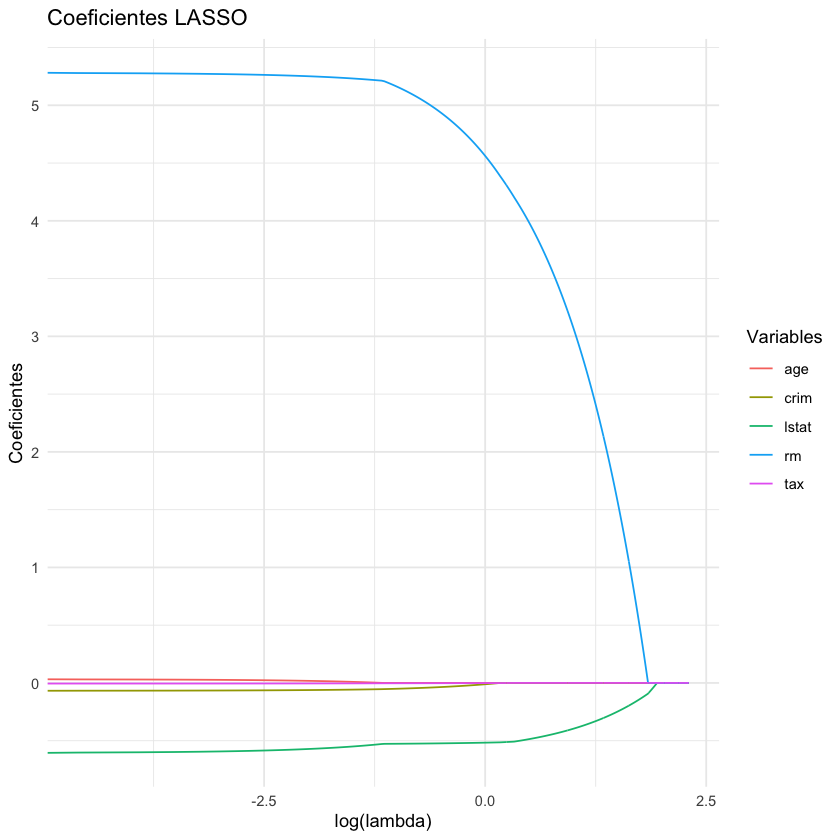

In [73]:
set.seed(2025)
# REGRESION LASSO
x_train <- train %>% select(-medv)
y_train <- train$medv
x_test <- test %>% select(-medv)
y_test <- test$medv

lam = seq(0, 10, by = 0.01)

# validacion cruzada de k-iteraciones (por defecto k = 10)
lasso_model <- cv.glmnet(as.matrix(x_train), y_train, alpha = 1, lambda = lam)
lasso_model$lambda.min
coef(lasso_model, s = "lambda.min")

predicciones_la_train <- predict(lasso_model, newx = as.matrix(x_train), type = "response", s = lasso_model$lambda.min)

coef_matrix <- coef(lasso_model$glmnet.fit)[-1,] # quitamos el intercepto
lambda_vals <- lasso_model$lambda

coef_df <- data.frame(lambda = rep(lambda_vals, each = nrow(coef_matrix)), 
                      coefficient = as.vector(coef_matrix), 
                      variable = rep(rownames(coef_matrix), times = length(lambda_vals)))

# trayectorias de los coeficientes
plot_coef <- ggplot(coef_df, aes(x = log(lambda), y = coefficient, color = variable)) + geom_line() + 
             labs(title = "Coeficientes LASSO", x = "log(lambda)", y = "Coeficientes", color = "Variables") + 
             theme_minimal()

print(plot_coef)

## c) Comparación de modelos

A continuación, hacemos las predicciones con los tres modelos entrenados y graficamos el valor predicho frente al real. Sobre esto, pintamos una línea discontinua que referencia la situación ideal, cuando la predicción coincide con el valor real ($y = x$). 

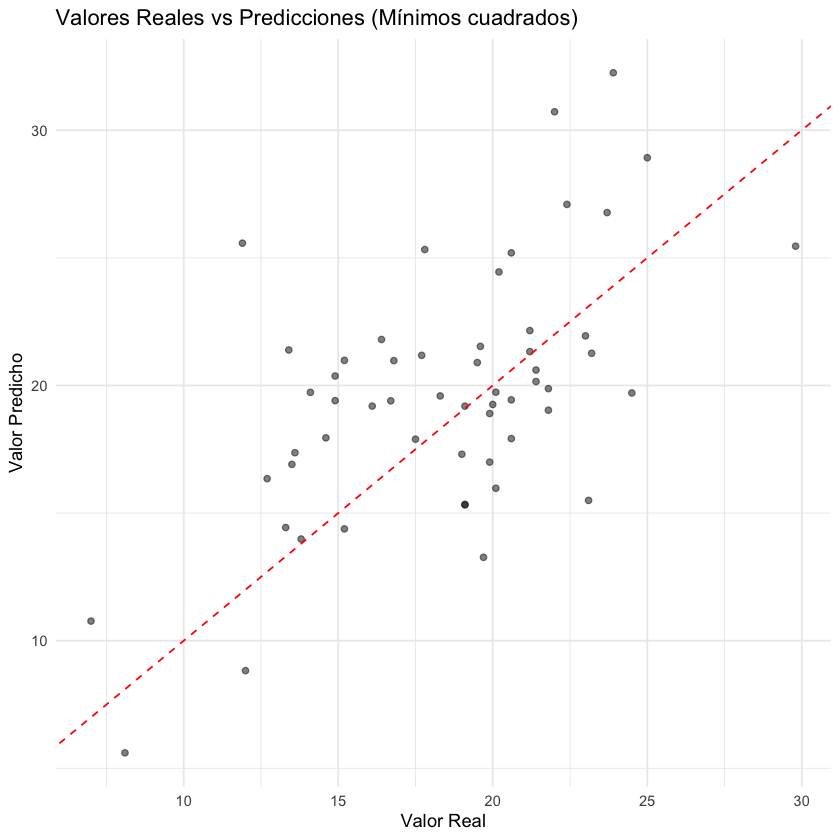

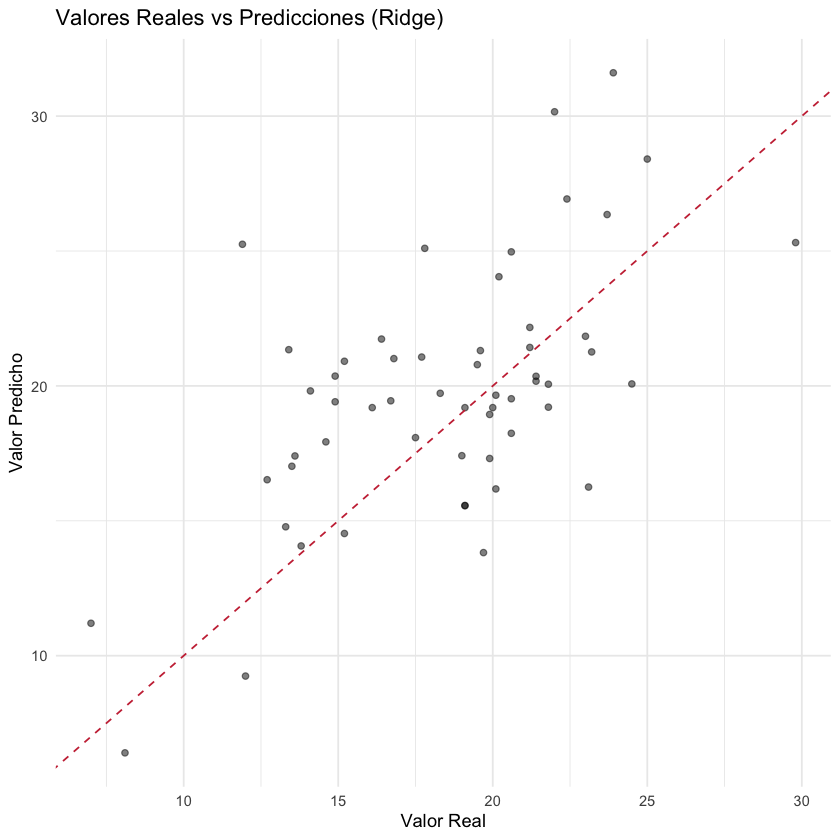

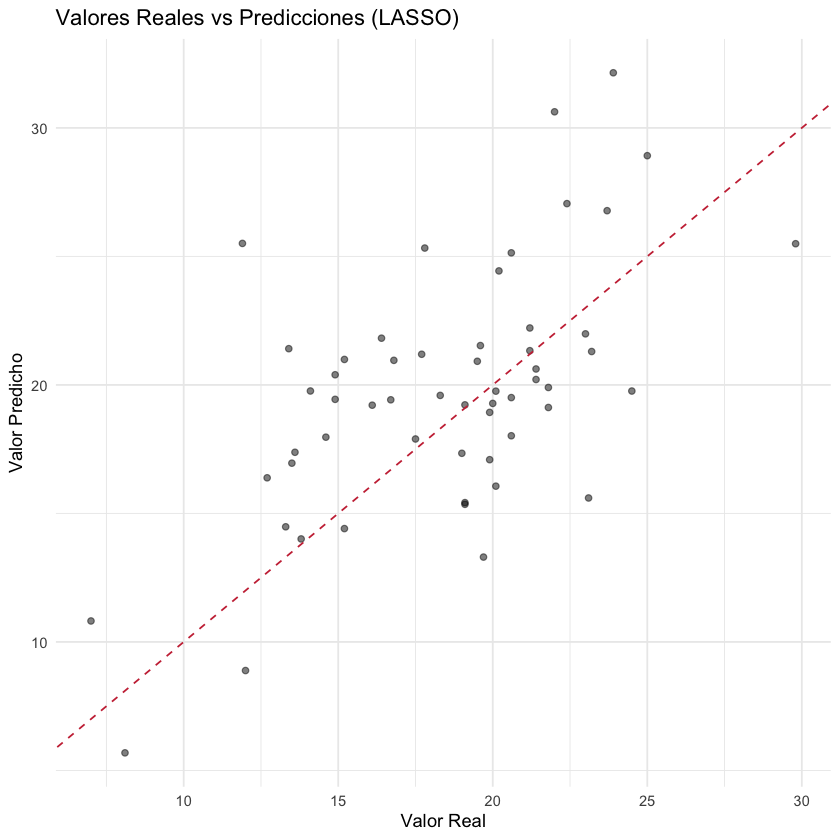

In [74]:
set.seed(2025)
# predicciones multilineal
test_pred_multi <- predict(multi_model, newdata = test)

# comparacion valor esperado - valor predicho
plotLSS <- ggplot(data = data.frame(real = test$medv, pred = test_pred_multi), aes(x = real, y = pred)) +
           geom_point(alpha = 0.5) +
           geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed") +
           labs(title = "Valores Reales vs Predicciones (Mínimos cuadrados)",
                x = "Valor Real",
                y = "Valor Predicho") +
           theme_minimal()

plotLSS


# predicciones RIDGE
predicciones_rg <- predict(ridge_model, newx = as.matrix(x_test), type = "response", s = ridge_model$lambda.min)

# comparacion valor esperado - valor predicho
plotRidge <- ggplot(data = data.frame(real = test$medv, pred = as.vector(predicciones_rg)), aes(x = real, y = pred)) +
             geom_point(alpha = 0.5) +
             geom_abline(intercept = 0, slope = 1, color = "#ca3142", linetype = "dashed") +
             labs(title = "Valores Reales vs Predicciones (Ridge)",
                  x = "Valor Real",
                  y = "Valor Predicho") +
             theme_minimal()

plotRidge

#predicciones LASSO
predicciones_la <- predict(lasso_model, newx = as.matrix(x_test), type = "response", s = lasso_model$lambda.min)

plotLASSO <- ggplot(data = data.frame(real = test$medv, pred = as.vector(predicciones_la)), aes(x = real, y = pred)) +
             geom_point(alpha = 0.5) +
             geom_abline(intercept = 0, slope = 1, color = "#ca3142", linetype = "dashed") +
             labs(title = "Valores Reales vs Predicciones (LASSO)",
                  x = "Valor Real",
                  y = "Valor Predicho") +
             theme_minimal()

plotLASSO

Para hacer una evaluación numérica de los resultados, evaluaremos el RMSE y el $R^2$. Sabemos que un RMSE bajo en test es lo ideal para un buen ajuste, ya que nos indica en cierto modo la cantidad media que se desviará la respuesta de la recta real de regresión. Además, buscamos un $R^2$ cercano a 1, lo que significa que una gran proporción de la variabilidad en la respuesta fue explicada por la regresión. 

     Model Train_RSE Train_MSE Train_RMSE  Train_R2 Test_RSE Test_MSE Test_RMSE
1 Multiple  5.582039  30.74370   5.544701 0.6595169 4.577652 18.70973  4.325475
2    Ridge  5.593841  30.87385   5.556424 0.6580756 4.408699 17.35413  4.165829
3    Lasso  5.582277  30.74632   5.544936 0.6594880 4.554423 18.52033  4.303526
      Test_R2
1 -0.02405413
2  0.05014285
3 -0.01368764


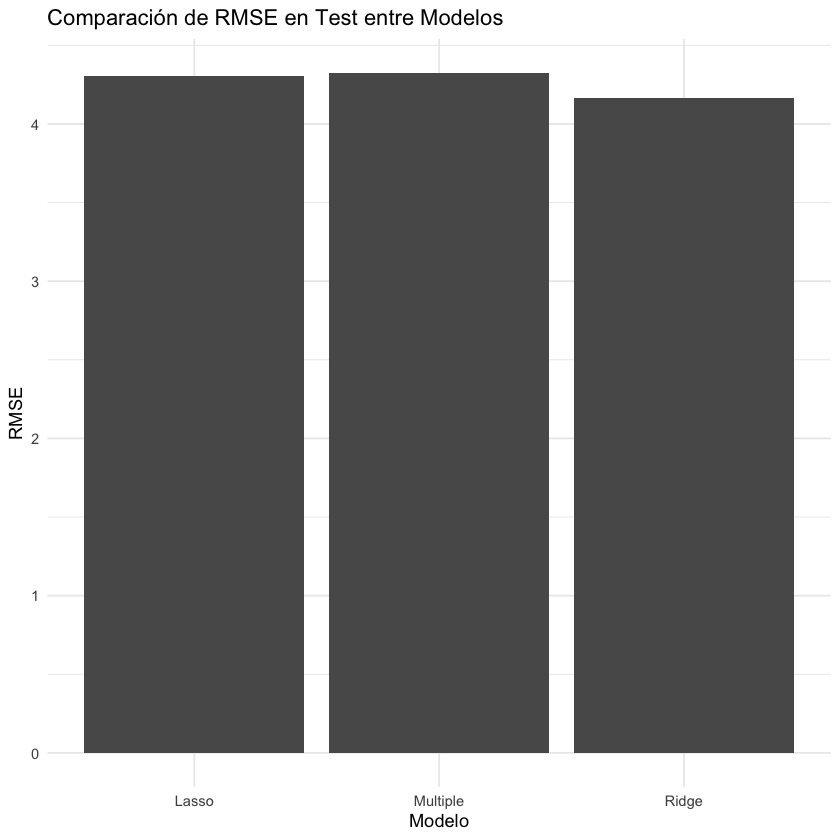

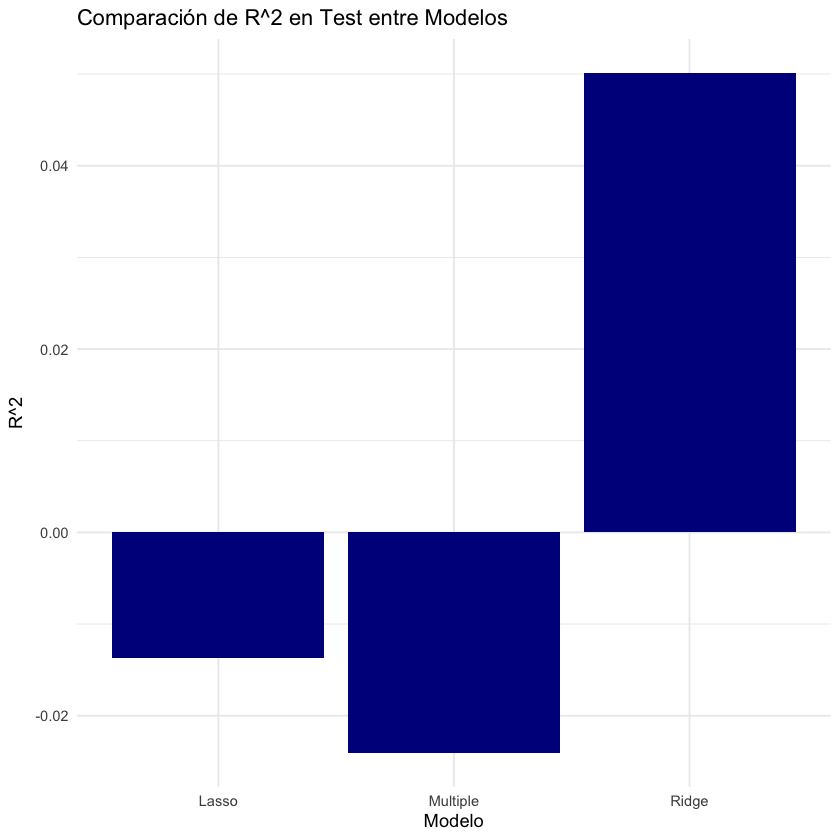

In [75]:
set.seed(2025)
# COMPARACION DE MODELOS

stats <- function(y, y_pred, fact = 2) {
    rse <- sqrt(sum((y - y_pred)**2) / (length(y) - fact))
    cat("RSE:", rse, "\n")

    r2 <- 1 - (sum((y - y_pred)^2) / sum((y - mean(y))^2))
    cat("R2:", r2, "\n")
}

# métricas de comparación
models_comparison <- data.frame(
  Model = c("Multiple", "Ridge", "Lasso"),
  Train_RSE = c(
    sqrt(sum((train_pred_multi - train$medv)**2) / (length(train$medv) - ncol(x_train) - 1)),
    sqrt(sum((predicciones_rg_train - y_train)**2) / (length(y_train) - ncol(x_train) - 1)), 
    sqrt(sum((predicciones_la_train - y_train)**2) / (length(y_train) - ncol(x_train) - 1))
  ),
  Train_MSE = c(
    mean((train_pred_multi - train$medv)^2),
    mean((predicciones_rg_train - y_train)^2),
    mean((predicciones_la_train - y_train)^2)
  ),
  Train_RMSE = c(
    sqrt(mean((train_pred_multi - train$medv)^2)),
    sqrt(mean((predicciones_rg_train - y_train)^2)),
    sqrt(mean((predicciones_la_train - y_train)^2))
  ),
  Train_R2 = c(
    1 - (sum((train$medv - train_pred_multi)^2) / sum((train$medv - mean(train$medv))^2)), 
    1 - (sum((y_train - predicciones_rg_train)^2) / sum((y_train - mean(y_train))^2)), 
    1 - (sum((y_train - predicciones_la_train)^2) / sum((y_train - mean(y_train))^2))
  ),
  Test_RSE = c(
    sqrt(sum((test_pred_multi - test$medv)**2) / (length(test$medv) - ncol(x_test) - 1)),
    sqrt(sum((predicciones_rg - y_test)**2) / (length(y_test) - ncol(x_test) - 1)), 
    sqrt(sum((predicciones_la - y_test)**2) / (length(y_test) - ncol(x_test) - 1))
  ),
  Test_MSE = c(
    mean((test_pred_multi - test$medv)^2),
    mean((predicciones_rg - y_test)^2),
    mean((predicciones_la - y_test)^2)
  ),
  Test_RMSE = c(
    sqrt(mean((test_pred_multi - test$medv)^2)),
    sqrt(mean((predicciones_rg - y_test)^2)),
    sqrt(mean((predicciones_la - y_test)^2))
  ),
  Test_R2 = c(
    1 - (sum((test$medv - test_pred_multi)^2) / sum((test$medv - mean(test$medv))^2)), 
    1 - (sum((y_test - predicciones_rg)^2) / sum((y_test - mean(y_test))^2)), 
    1 - (sum((y_test - predicciones_la)^2) / sum((y_test - mean(y_test))^2))
  )
)

print(models_comparison)

# Visualización final comparativa
plot_rmse <- ggplot(models_comparison, aes(x = Model, y = Test_RMSE)) +
             geom_bar(stat = "identity") +
             labs(title = "Comparación de RMSE en Test entre Modelos",
                  y = "RMSE",
                  x = "Modelo") + theme_minimal()

plot_r2 <- ggplot(models_comparison) +
    geom_bar(aes(x = Model, y = Test_R2), stat = "identity", fill = "darkblue") +
    labs(title = "Comparación de R^2 en Test entre Modelos",
         y = "R^2",
         x = "Modelo") +
    theme_minimal()

plot_rmse
plot_r2

En base a estas métricas, vemos que la regresión Ridge es la mejor opción en este caso. Ya comentamos en el apartado a del ejercicio por qué podríamos preferir un método de regularización frente a regresión lineal. ¿Por qué aquí sería mejor Ridge que Lasso? Por el simple hecho de que, como vimos en los resultados, Lasso en este caso no reduce ningún coeficiente a 0. Lasso produce modelos más simples que Ridge, de modo que, en este caso, parece que es necesario más complejidad en el modelo para ajustar los datos. De hecho, el modelo más complejo es la regresión múltiple, y resulta el peor. Si metemos regularización, obtenemos Ridge y Lasso. De estos dos, Lasso suele ser más simple por el hecho de reducir variables a cero, lo que es de gran utilidad en casos de alta dimensión. En este caso, sin embargo, esto se pierde y es el modelo de regresión Ridge el que mejores resultados da.

## d) PCA. Reducción de dimensión

Estamos usando valores con distintas escalas y unidades, por lo que usaremos la matriz de correlación para hacer el análisis de componentes principales.

Importance of components:
                          Comp.1    Comp.2    Comp.3     Comp.4     Comp.5
Standard deviation     1.8541091 1.0284820 0.8252296 0.58521732 0.52930866
Proportion of Variance 0.5729534 0.1762959 0.1135006 0.05707989 0.04669461
Cumulative Proportion  0.5729534 0.7492493 0.8627499 0.91982983 0.96652444
                           Comp.6
Standard deviation     0.44816669
Proportion of Variance 0.03347556
Cumulative Proportion  1.00000000

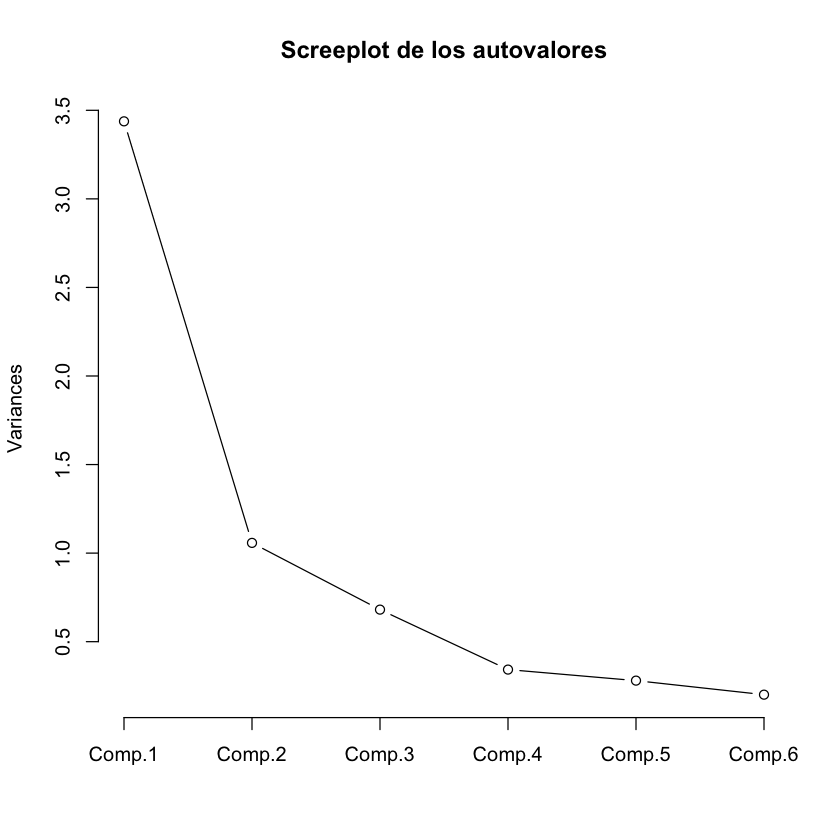

In [76]:
set.seed(2025)
pca_hitters_muestral <- princomp(train, cor=TRUE) # usar mat correlacion cuadno vars dif escalas o unidades (estandariza)
summary(pca_hitters_muestral)
screeplot(pca_hitters_muestral, type = "lines", main="Screeplot de los autovalores")

Cogeremos como criterio que las componentes expliquen al menos el 90% de la varianza original de los datos, por lo que nos quedaremos con las 5 primeras componentes, que explican un 91%. Esto es asi porque si cogieramos 5 componetnes, para explicar el 96%, no tendríamos reducción de dimensión. Coger 3 componentes únicamente dejaríamos demasiada varianza sin explicar.

## e) Predicción con modelo reducido

In [77]:
set.seed(2025)
# regresion con PCA 5 primeras componentes principales
pca_scores <- pca_hitters_muestral$scores[,1:4]
train_pred_vars <- as.data.frame(pca_scores[, 1:4])

# modelo de regresión lineal
model_pca <- lm(train$medv ~ ., data = train_pred_vars)

summary(model_pca)


Call:
lm(formula = train$medv ~ ., data = train_pred_vars)

Residuals:
     Min       1Q   Median       3Q      Max 
-16.2450  -1.9489  -0.5549   1.3096  20.5987 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 23.04356    0.17546 131.334  < 2e-16 ***
Comp.1      -4.21674    0.09463 -44.559  < 2e-16 ***
Comp.2      -3.64172    0.17060 -21.347  < 2e-16 ***
Comp.3       1.40597    0.21262   6.613 1.08e-10 ***
Comp.4      -0.52579    0.29982  -1.754   0.0802 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.722 on 445 degrees of freedom
Multiple R-squared:  0.8483,	Adjusted R-squared:  0.8469 
F-statistic:   622 on 4 and 445 DF,  p-value: < 2.2e-16


In [69]:
set.seed(2025)
test_pred_vars <- predict(pca_hitters_muestral, newdata = test)
test_pred_vars <- as.data.frame(test_pred_vars[, 1:4])

y_pred_test <- predict(model_pca, newdata = test_pred_vars)
rmse <- sqrt(mean(y_pred_test - test$medv)^2)
r_cuadrado <- 1 - (sum((test$medv - y_pred_test)^2) / sum((test$medv - mean(test$medv))^2))
cat("RMSE:", rmse)
cat("\nR2:", r_cuadrado)

RMSE: 1.308542


R2: 0.3841431

Parece que con este modelo, estamos reduciendo en gran medida el rmse y aumentando el $R^2$, mejorando los resultados del apartado c. 